## Automated Portfolio Management

### Complete Example

#### Includes:
- Data collection
- Goal setting and probability
- Projections

In [1]:
from projections import Projection
from datetime import date
from goals import Goal
import riskevaluation as rv
import pyportfolio as py

questionsFile = '../Data/questionnaire.csv'
answersFile = '../Data/answers.csv'

In [2]:
myGoal = Goal('Retirement', targetYear=2041, targetValue=3000000, initialContribution=50000,monthlyContribution=500,priority='Wishes')

In [3]:
toleranceQuestions = rv.RiskQuestionnaire()
toleranceQuestions.loadQuestionnaire(questionsFile,answersFile,"Tolerance")

capacityQuestionnaire = rv.RiskQuestionnaire()
capacityQuestionnaire.loadQuestionnaire(questionsFile, answersFile, "Capacity")

toleranceQuestions.answerQuestionnaire()
capacityQuestionnaire.answerQuestionnaire()

In general, how would your bestfriend describe you as a risk taker?
0:A real gambler
1:Willing to take risks after doing alot of research
2:Cautious
3:A real risk avoider


You are on TV at a game show. Which of the following options would you choose?
0:$1,000 in cash
1:A 50% chance at $5,000
2:A 25% chance at %10,000
3:A 5% change at $100,000


What word comes to mind first wen you think of risk?
0:Loss
1:Uncertainty
2:Opportunity
3:Thrill


You are able to spend money regularly.
0:Completely False
1:Somewhat True
2:Completely True


You can pay all your monthly bills on time.
0:Completely False
1:Somewhat True
2:Completely True


If you lose money investing today, your current lifestyle will not change.
0:Completely False
1:Somewhat True
2:Completely True


You do not need to draw more that 5% of your investment portfolio for the next 5 years.
0:Completely False
1:Somewhat True
2:Completely True




In [4]:
toleranceQuestions.calculateScore()
capacityQuestionnaire.calculateScore()

riskCapScore = capacityQuestionnaire.score
riskTolScore = toleranceQuestions.score

Risk Score:
Cautious: 4
A 50% chance at $5,000: 2
Loss: 1
Total Risk Score: 7

Risk Score:
Completely True: 3
Completely True: 3
Somewhat True: 2
Completely True: 3
Total Risk Score: 11



In [5]:
myPortfolioId = py.Portfolio.getPortfolioMapping(riskTolScore, riskCapScore)

In [6]:
myPortfolio = py.Portfolio(portfolioName='Moderate Growth',tickerString="VTI TLT IEI GLD DBC",
                           expectedReturn=0.06, 
                           riskBucket=myPortfolioId)

[*********************100%***********************]  5 of 5 completed


In [7]:
yearsToGoal = myGoal.targetYear - date.today().year
myProjection = Projection(expectedReturn = myPortfolio.expectedReturn,
                          expectedRisk = myPortfolio.expectedRisk,
                          initialInvestment= myGoal.initialContribution,
                          monthlyInvestment= myGoal.monthlyContribution,
                          years = yearsToGoal)

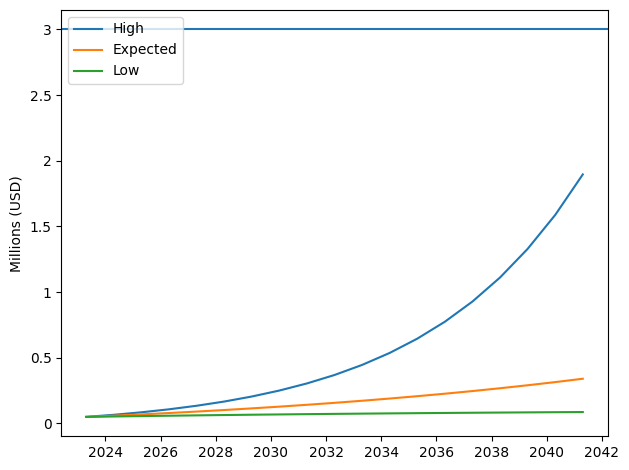

In [8]:
myProjection.visualize(myGoal.targetValue)

### Goal Probability

Since our goal looks very unrealistic, we can add a feature that allows us to calculate the probability of reaching our goal using some stats magic. 

We will use the z-score which assumes that our data follows a normal distribution.

In [24]:
def goalProbabilityForAmount(goalAmount, expectedReturn, portfolioRisk, years, initialInvestment, monthlyInvestment) -> float:
    '''
    calculate the probability of reaching a goal amount
    '''
    import scipy.stats as st
    import math as math
    from projections import Projection
    std = portfolioRisk/math.sqrt(years)
    amount = 0
    minReturn = 0.00
    while (amount < goalAmount):
        minReturn = minReturn + 0.0000001
        amount = Projection.returnProjection(minReturn,
            initialInvestment, monthlyInvestment, years)
    z_score = (minReturn-expectedReturn)/std
    return 1-st.norm.cdf(z_score)

def calculateMonthlyMinimum(exprectedReturn, initialInvestment, years, goalAmount) -> float:
    '''
    uses the future value formula to find out the needed monthly contribution
    '''
    monthlyInvestment = (goalAmount - (initialInvestment*pow(
        1 + exprectedReturn / 12, (years*12))))/((pow(
        1 + exprectedReturn / 12, (years*12)) - 1)/(exprectedReturn/12))
    return monthlyInvestment

In [12]:
#the probability of reaching our goal in practically
goalProbabilityForAmount(myGoal.targetValue,
                         myPortfolio.expectedReturn,
                         myPortfolio.expectedRisk,
                         yearsToGoal,
                         myGoal.initialContribution,
                         myGoal.monthlyContribution)

5.726635354807996e-08

In [28]:
monthlyMin = calculateMonthlyMinimum(myPortfolio.expectedReturn,
                        myGoal.initialContribution,
                        yearsToGoal,
                        myGoal.targetValue)

print(f'Minumum monyhly contribution: ${monthlyMin:.2f}')

Minumum monyhly contribution: $7365.79


Let's see how the probability changes when we update our monthly contribution to the new minumum. I think we will use a nice round number too, so let's contribute $7500 *(yikes!)* each month .

In [29]:
myGoal.monthlyContribution = 7500.00

In [30]:
#updated probability of reaching our goal in practically
goalProbabilityForAmount(myGoal.targetValue,
                         myPortfolio.expectedReturn,
                         myPortfolio.expectedRisk,
                         yearsToGoal,
                         myGoal.initialContribution,
                         myGoal.monthlyContribution)

# 52% is alot better than where we were!

0.52328865387644

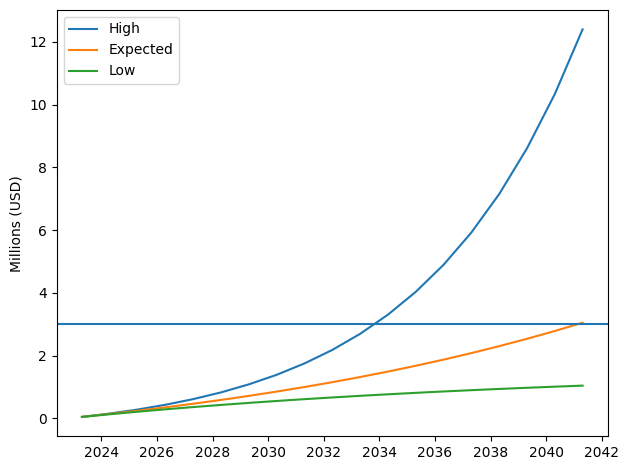

In [31]:
myProjection = Projection(myPortfolio.expectedReturn,
                          myPortfolio.expectedRisk,
                          myGoal.initialContribution,
                          myGoal.monthlyContribution,
                          yearsToGoal)
myProjection.visualize(myGoal.targetValue)


In [32]:
#now let's extend our retirement age a bit to see if we can make things even better
goalProbabilityForAmount(myGoal.targetValue,
                         myPortfolio.expectedReturn,
                         myPortfolio.expectedRisk,
                         yearsToGoal + 2, #add two years
                         myGoal.initialContribution,
                         myGoal.monthlyContribution)

0.7320625806673748

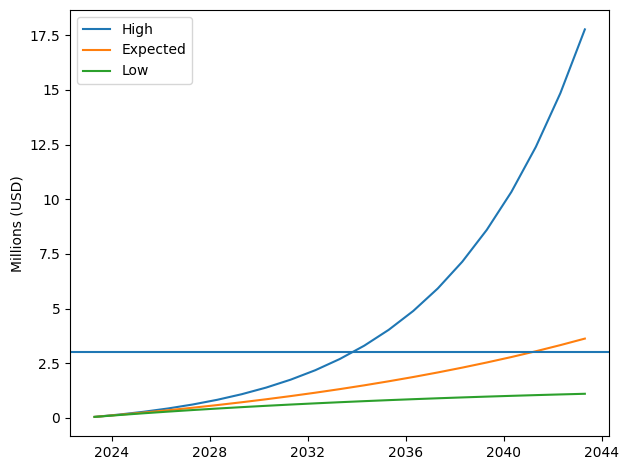

In [33]:
myProjection = Projection(myPortfolio.expectedReturn,
                          myPortfolio.expectedRisk,
                          myGoal.initialContribution,
                          myGoal.monthlyContribution,
                          yearsToGoal + 2
                          )
myProjection.visualize(myGoal.targetValue)